In [12]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch
from torchvision.models import vgg16
from torchvision import models
from torch.autograd import Variable
import copy
from torch import nn

In [27]:
def prep_img(orig_img):
  rsz_img = cv2.resize(orig_img,(224,224))
  img_arr = (np.float32(rsz_img)).transpose(2,0,1)

  mean = [0.485, 0.456, 0.406]
  stdev = [0.229, 0.224, 0.225]

  for C in range(3):
    img_arr[C] = (img_arr[C]/255-mean[C])/stdev[C]

  img_arr = (torch.from_numpy(img_arr).float()).unsqueeze_(0)
  img_var = Variable(img_arr, requires_grad=True)

  return img_var

In [13]:
def prep_inv_img(img_var):
  mean = [0.485, 0.456, 0.406]
  stdev = [0.229, 0.224, 0.225]
  
  rec_img = copy.copy(img_var.data.numpy()[0])

  for C in range(3):
    rec_img[C] = (rec_img[C]*stdev[C])+mean[C]

  rec_img = np.clip(rec_img,0,1)
  rec_img = np.round(rec_img * 255)

  rec_img = np.uint8(rec_img).transpose(1, 2, 0)
  return rec_img


In [62]:
class fooling_example():
    def __init__(self, model):
        self.model = model
        self.model.eval()

    def generate(self, img, img_class):
        class_var = Variable(torch.from_numpy(np.asarray([img_class])))
        loss_func = nn.CrossEntropyLoss()

        proc_img = prep_img(img)
        for i in range(10):
            proc_img.grad = None
            out = self.model(proc_img)

            loss = loss_func(out, class_var)
            loss.backward()

            diff = 1e-2 * torch.sign(proc_img.grad.data)
            proc_img.data = proc_img.data + diff
            rec_img = prep_inv_img(proc_img)

            prep_rec_img = prep_img(rec_img)
            new_out = self.model(prep_rec_img)
            _, new_pred = new_out.data.max(1)
            new_prob = nn.functional.softmax(
                new_out)[0][new_pred].data.numpy()[0]

            print('No. of Iters:', str(i), 'Real Label:', img_class,
                  'Predicted Label:', new_pred.data.numpy()[0], 'Probability:',  new_prob)
            noise_image = img - rec_img

        fig = plt.figure()
        fig.subplots_adjust(hspace=0.4, top=0.85)
        ax1 = fig.add_subplot(1, 3, 1)
        plt.imshow(img)
        ax2 = fig.add_subplot(1, 3, 2)
        plt.imshow(rec_img)
        ax3 = fig.add_subplot(1, 3, 3)
        plt.imshow(noise_image)
        ax1.title.set_text("Original")
        ax2.title.set_text("Recreated")
        ax3.title.set_text("Noise")
        plt.show()

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
<ipython-input-62-377edc99ba57>:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  new_prob = nn.functional.softmax(


No. of Iters: 0 Real Label: 366 Predicted Label: 109 Probability: 0.49386105
No. of Iters: 1 Real Label: 366 Predicted Label: 109 Probability: 0.62703884
No. of Iters: 2 Real Label: 366 Predicted Label: 109 Probability: 0.6902871
No. of Iters: 3 Real Label: 366 Predicted Label: 109 Probability: 0.8680306
No. of Iters: 4 Real Label: 366 Predicted Label: 109 Probability: 0.9437923
No. of Iters: 5 Real Label: 366 Predicted Label: 109 Probability: 0.98842514
No. of Iters: 6 Real Label: 366 Predicted Label: 109 Probability: 0.997454
No. of Iters: 7 Real Label: 366 Predicted Label: 109 Probability: 0.9995827
No. of Iters: 8 Real Label: 366 Predicted Label: 109 Probability: 0.99994504
No. of Iters: 9 Real Label: 366 Predicted Label: 109 Probability: 0.9999893


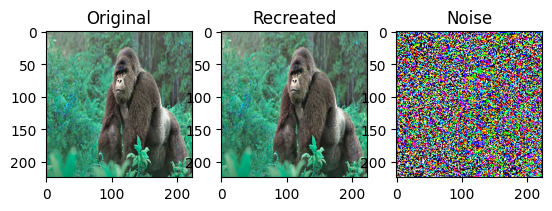

In [63]:
img = cv2.imread("gorilla.jpg")
img = cv2.resize(img,(224,224))
model = vgg16(pretrained=True)
FGS_untargeted = fooling_example(model)
FGS_untargeted.generate(img, 366)